Tutorial followed: https://realpython.com/k-means-clustering-python/

Input Data: Cancer dataset from The Cancer Genome Atlas (TCGA)
            881 samples of 5 different cancer subtypes
Goal: Understand how k-means clustering works on the data 

In [15]:
#1.Import modules 
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [15]:
#2. Download data
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

complete_url = urllib.parse.urljoin(uci_tcga_url,archive_name)
r = urllib.request.urlretrieve(complete_url) #how to view the downloaded data.


In [16]:
#3. Extract data
#Extract data from the archive
tar = tarfile.open(archive_name, "r:gz")  #Question: if u dont put space after comma, it wouldnt work. why ? 
tar.extractall() #if no folder is specified, it will download it where the notebook is. 
tar.close()


In [11]:
#3. Read extracted data 
#NewStuff: Variable Inspector in notebook: https://stackoverflow.com/questions/37718907/variable-explorer-in-jupyter-notebook
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labelsfile = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

#data file structure: 
# row1 = column headers
# col1 = row headers
# nfeatures = ncol = some thousands
# nsamples = nrow = 801

#we need column headers. We probably dont need row headers.
#question: its not a text file, but a csv. why no csvread? try and check

data = np.genfromtxt(
    datafile,
    delimiter = ',',
    usecols = range(1,20532), #question: how can u specify column number when u dont even know that? 
    skip_header = 1    
)

#labels file structure
#row1: column header
#col1 : row headers
#ncol = 1
#nrow = nrow(datafile) = 801 
#5 categories in the output array

labels = np.genfromtxt(
    labelsfile,
    usecols=(1,), #todo: understand this function better. It has too many arguments to be filled for just file read.
    delimiter=',',
    skip_header=1,
    dtype="str"
)

In [23]:
# Explore data
print(data.shape)
print(data[0:5,0:4])
print(labels[0:5])

[[0.         2.01720929 3.26552691 5.47848651]
 [0.         0.59273209 1.58842082 7.58615674]
 [0.         3.51175898 4.32719872 6.88178696]
 [0.         3.66361787 4.50764878 6.65906827]
 [0.         2.65574107 2.82154696 6.53945353]]
(801, 20531)
[4 3 4 4 0]


In [31]:
#4. Preprocess the data
#1. Encode categories into numbers. Question: is this really needed here? 
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(labels)

print(labels[0:5])

print(len(labelencoder.classes_))
n_clusters = len(labelencoder.classes_)

print(labelencoder.classes_)

# 2. Reduce the dimensions (because some 20k features) 
# 3. Scale the features (mixmaxscaling) #question: understand why is this needed, and the implications of not doing this

#Building the preprocessor pipeline
preprocessor = Pipeline(
    [
        ("scaler",MinMaxScaler()),
        ("pca",PCA(n_components=2,random_state=42)) #question: why a hanging comma. <was there in the tutorial after the braces here. I have not put it and it has not errored 
    ]
)

[4 3 4 4 0]
5
[0 1 2 3 4]


In [33]:
#5. Form clusters from the data
#Make cluster pipeline
#Config: 

clusterer = Pipeline(
    [
        (
            "kMeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42 
                )
            )
        ]
)

#Chain the individual pipelines into 1
pipe = Pipeline(
    [
        ("preprocessor",preprocessor),
        ("clusterer",clusterer)
    ]
)

#fit pipeline on the data
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kMeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [37]:
#6. Analyse the clusters
#Calculate silhouette score
preprocessed_data = pipe["preprocessor"].transform(data)
predicted_labels = pipe["clusterer"]["kMeans"].labels_

print("Silhouette score:", silhouette_score(preprocessed_data,predicted_labels))

#calculate ARI Index
#Question: cant u use any other metric or simply true/all as metric? 
#why complicate? 
print("ARI Index: ",adjusted_rand_score(labels,predicted_labels))

Silhouette score: 0.5118775528450326
ARI Index:  0.722276752060253


Silhouette Score : Range [-1,1]: 0 = Significantly Overlapping clusters
                                 1 = Well separated
                                 
Adjusted Rand Index : Range[-1,1]: 0 = Clusters assigned randomly
                                   1 = true labels and predicted form identical clusters 

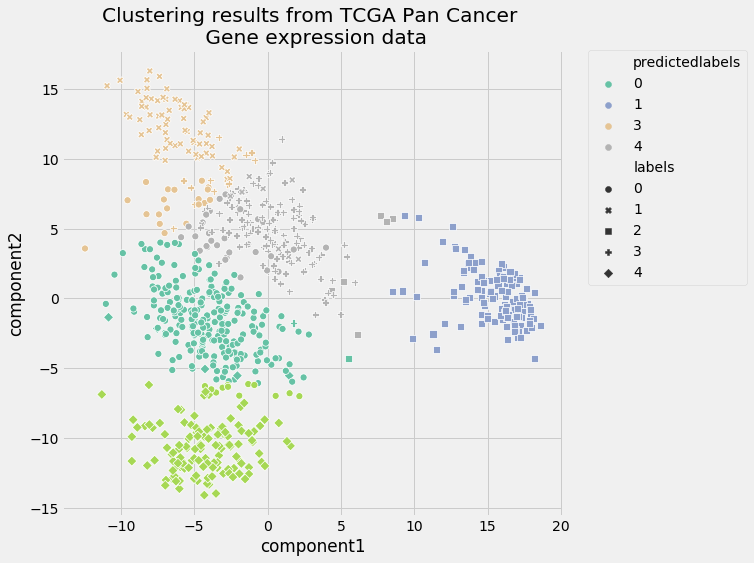

In [41]:
#Plot clusters:
#Information: new stuff :Pandas dataframe and seaborn plotting library
#todo: try out simple plotting. I am just not used to python datastructures yet. 

pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data), #question: what exactly does transform do here and why is it needed?  
    columns=["component1","component2"]
)

#add label columns
pcadf["predictedlabels"] = pipe["clusterer"]["kMeans"].labels_
pcadf["labels"] = labelencoder.inverse_transform(labels) #question: why why why. and what what what

#plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,8))

scat = sb.scatterplot(
    "component1",
    "component2",
    s=50,
    data=pcadf,
    hue="predictedlabels",
    style="labels",
    palette="Set2"    
)

scat.set_title("Clustering results from TCGA Pan Cancer \n Gene expression data")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [50]:
#7. Tune the parameters to improve the pipeline
#2 features were a little too less to explain all the variance in the data

#method1: Plot number of components -> explained variance
#method2: use clustering eval metrics for different component numbers

#trying out method2:
silhouette_scores = []
ari_scores = []

for componentindex in range(2,11):
    pipe["preprocessor"]["pca"].n_components = componentindex
    pipe.fit(data)
    
    silhouettescoreitn = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kMeans"].labels_
        
    )
    
    ariitn = adjusted_rand_score(labels,
                        pipe["clusterer"]["kMeans"].labels_)
    
    silhouette_scores.append(silhouettescoreitn)
    ari_scores.append(ariitn)
    

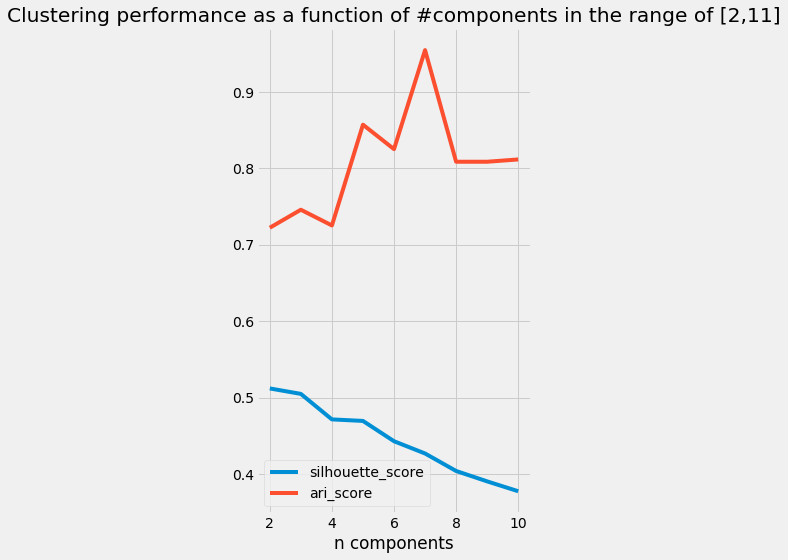

In [59]:
#plot the fine tuning experiment results
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,8))
plt.plot(
    range(2,11),
    silhouette_scores,
    label="silhouette_score"
)

plt.plot(
    range(2,11),
    ari_scores,
    label="ari_score"
)

plt.xlabel("n components")
plt.legend()
plt.title("Clustering performance as a function of #components in the range of [2,11]")
plt.tight_layout()
plt.show()

Observations:
1. Silhouette score decreases as n_components increase because it depends on distance 
2. ARI score tops at ncomponent 7. 

" In situations when cluster labels are available, as is the case with the cancer dataset used in this tutorial, ARI is a reasonable choice. ARI quantifies how accurately your pipeline was able to reassign the cluster labels. " : Question: Then does it not become a supervised machine learning problem? 

"The silhouette coefficient, on the other hand, is a good choice for exploratory clustering because it helps to identify subclusters. These subclusters warrant additional investigation, which can lead to new and important insights." Question: What does this mean? "subclusters warrant additional investigation. 


Other questions: 
1. why only components checked between [2,11] what if more will help? in this case it was fine, but what about other cases when thats not the case. 


Summary: 